This is the main file for feature comparisons and hyperparameters optimization

In [9]:
# import functions
import importlib
import functions
importlib.reload(functions)
from functions import *

import features

In [2]:
# import original data
# import original data
data1 = arff.loadarff(r'insects/InsectSound_TRAIN.arff')
train= pd.DataFrame(data1[0])

data2 = arff.loadarff(r'insects/InsectSound_TEST.arff')
test= pd.DataFrame(data2[0])

# get rid of empty data points
train = train[~train.duplicated(subset=train.columns[:-1], keep=False)]
test = test[~test.duplicated(subset=test.columns[:-1], keep=False)]

# combine trainand test set
raw_data = pd.concat([train, test], axis=0)

In [25]:
# import extracted features
baseline = pd.read_csv('features/baseline.csv')
fft = pd.read_csv('features/fft.csv')
ti = pd.read_csv('features/ti.csv')
rolloff = pd.read_csv('features/rolloff.csv')
spec = pd.read_csv('features/spec.csv')
wt = pd.read_csv('features/wavelets.csv')

pre-porcessing every features

In [4]:
def pre_features(ratio, data):
    training, testing = split(ratio, data)
    # split it into data and labels
    X_train, y_train, X_test, y_test = prep(training, testing)
    
    return X_train, y_train, X_test, y_test

In [27]:
raw_X_train, y_train, raw_X_test, y_test = pre_features(0.6, raw_data)
baseline_X_train, y_train, baseline_X_test, y_test = pre_features(0.6, baseline)
fft_X_train, y_train, fft_X_test, y_test = pre_features(0.6, fft)
ti_X_train, y_train, ti_X_test, y_test = pre_features(0.6, ti)
rolloff_X_train, y_train, rolloff_X_test, y_test = pre_features(0.6, rolloff)
spec_X_train, y_train, spec_X_test, y_test = pre_features(0.6, spec)
wt_X_train, y_train, wt_X_test, y_test = pre_features(0.6, wt)

fit every feature by knn

In [28]:
# store result of all the features
result = {}

In [29]:
%%time
result['raw_data cv'] = knn_cv(raw_X_train, y_train, raw_X_test, y_test, 5)
result['raw_data'] = simple_knn(raw_X_train, y_train, raw_X_test, y_test)
result['baseline cv'] = knn_cv(baseline_X_train, y_train, baseline_X_test, y_test, 5)
result['baseline'] = simple_knn(baseline_X_train, y_train, baseline_X_test, y_test)
result['fft cv'] = knn_cv(fft_X_train, y_train, fft_X_test, y_test, 5)
result['fft'] = simple_knn(fft_X_train, y_train, fft_X_test, y_test)
result['stft cv'] = knn_cv(ti_X_train, y_train, ti_X_test, y_test, 5)
result['stft'] = simple_knn(ti_X_train, y_train, ti_X_test, y_test)
result['rolloff cv'] = knn_cv(rolloff_X_train, y_train, rolloff_X_test, y_test, 5)
result['rolloff'] = simple_knn(rolloff_X_train, y_train, rolloff_X_test, y_test)
result['spec cv'] = knn_cv(spec_X_train, y_train, spec_X_test, y_test, 5)
result['spec'] = simple_knn(spec_X_train, y_train, spec_X_test, y_test)
result['wave cv'] = knn_cv(wt_X_train, y_train, wt_X_test, y_test, 5)
result['wave'] = simple_knn(wt_X_train, y_train, wt_X_test, y_test)

Wall time: 2min 29s


result

In [30]:
result_df = pd.DataFrame(list(result.items()), columns=['feature', 'F1'])
# change the format of result
result_table = {'feature': ['raw data', 'baseline', 'fft', 'ti', 'rolloff', 'spec', 'wavelet'],
        'cv score': list(result_df[result_df.index % 2 != 1]['F1']),
        'test score': list(result_df[result_df.index % 2 != 0]['F1'])}
table_df = pd.DataFrame(result_table)
table_df

,feature,cv score,test score
0,raw data,0.531782,0.534335
1,baseline,0.160390,0.156832
2,fft,0.687941,0.695270
3,ti,0.688423,0.693667
4,rolloff,0.327769,0.330360
5,spec,0.642515,0.644681
6,wavelet,0.596443,0.599072


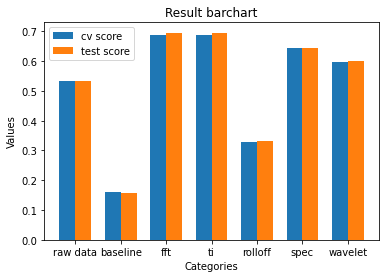

In [31]:
# display
bar_width = 0.35
bar_positions = range(len(table_df['feature']))

plt.bar(bar_positions, table_df['cv score'], width=bar_width, label='cv score')
plt.bar([pos + bar_width for pos in bar_positions], table_df['test score'], width=bar_width, label='test score')

# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Result barchart')

# Adding legend
plt.legend()

# Adjusting x-axis ticks and labels
plt.xticks([pos + bar_width/2 for pos in bar_positions], table_df['feature'])

# Display the chart
plt.show()


looks like Temporal Integration is tyhe best feature 

optimize the hyperparameters, number of neightbors and weights

In [33]:
%%time
ns = [10, 15, 20, 25, 30, 35, 40, 45, 50]
weights = ['uniform', 'distance']
grid_search_stft = grid_search_cv(ti_X_train, y_train, ns, weights, 5)

Wall time: 4min 2s


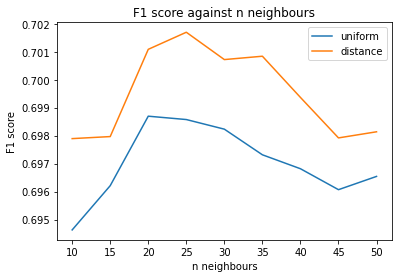

the best result of stft when use distance for n is 25, which is 0.7016941556633408


In [34]:
# print the curve
plt.plot(ns, list(grid_search_stft.values())[0], label=weights[0])
plt.plot(ns, list(grid_search_stft.values())[1], label=weights[1])
plt.title('F1 score against n neighbours')
plt.xlabel('n neighbours')
plt.ylabel('F1 score')
plt.legend()
plt.show()

# locate the best parameter
best_weight = max(grid_search_stft, key=lambda k: max(enumerate(grid_search_stft[k]), key=lambda x: x[1])[1])
best_n = ns[max(enumerate(grid_search_stft[best_weight]), key=lambda x: x[1])[0]]
max_result = max((max(lst) for lst in grid_search_stft.values()))

print(f'the best result of stft when use {best_weight} for n is {best_n}, which is {max_result}')

In [36]:
# the best model
knn_classifier = KNeighborsClassifier(n_neighbors=best_n, weights=best_weight)

# Train the classifier on the training data
knn_classifier.fit(ti_X_train, y_train)

# Make predictions on the test data
y_pred = knn_classifier.predict(ti_X_test)

# Evaluate the accuracy of the classifier
f1 = f1_score(y_test, y_pred, average='weighted')

f1

0.7030983511013146

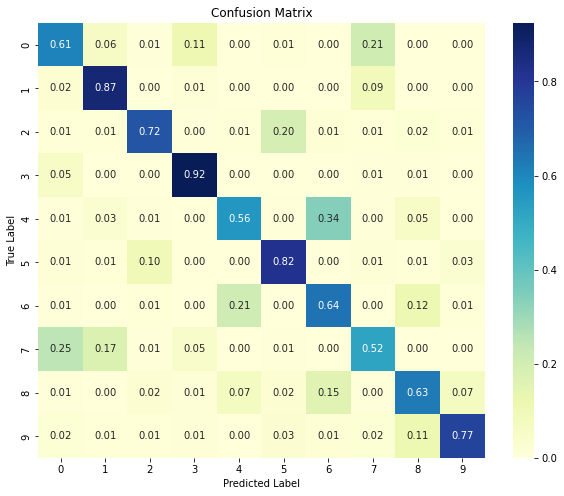

In [37]:
# seems not allowed to use, just here to see
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
conf_mat_norm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_norm, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
